# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abstract_udmis import AbstractUDMIS

%matplotlib inline

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [2]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

We will execute classical simulated annealing.  
  
The cooling schedule is given: $$T(t) = T_i(\frac{T_f}{T_i})^{\frac{t}{N}}.$$   
  
Let's try this.

In [3]:
u = 1.35
V = 6

# generate a random graph with 'V' vertices
#graph = [(np.random.uniform(low=0, high=5), np.random.uniform(low=0, high=5)) for i in range(V)]

graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)

6


Execute the simulated annealing.  
We store the energy of the result of annealing for each step.

In [4]:
N = 500
t = np.arange(N+1)
T_i = 100
T_f = 0.01
E_ = []
T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    E_.append(E)
    if t % 10 == 0:
        print(udmis.occupations)

[False  True False  True  True False]
[False  True False False False False]
[False  True  True  True  True False]
[False  True  True False  True False]
[False False False False  True False]
[ True False False  True  True  True]
[ True  True False False False False]
[ True False False False False False]
[ True  True  True  True  True False]
[False  True False  True False  True]
[ True  True  True  True False False]
[False False  True False False  True]
[False False False False False False]
[False False  True  True  True False]
[ True  True  True  True  True False]
[False False  True False  True  True]
[ True  True False  True False False]
[False False False False False  True]
[ True False  True  True  True False]
[False  True  True False  True  True]
[ True  True False  True False  True]
[False  True  True  True False  True]
[False  True False False False False]
[False False False  True  True False]
[False  True False  True  True False]
[False False  True  True  True False]
[False False

Plot Step vs. Resulting energy.

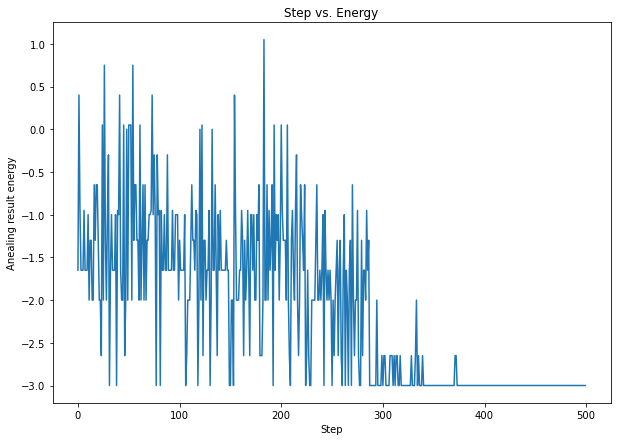

In [5]:
t = np.arange(N)

plt.figure(figsize=(10,7))
plt.title("Step vs. Energy")
plt.xlabel("Step")
plt.ylabel("Anealing result energy")
plt.plot(t,E_)
# Save figure
plt.savefig("./figures/task1_default_EvsS.png")
plt.show()

Energy gets minimum value about 350 steps.  
Furthermore, plot Temperature vs. energy.

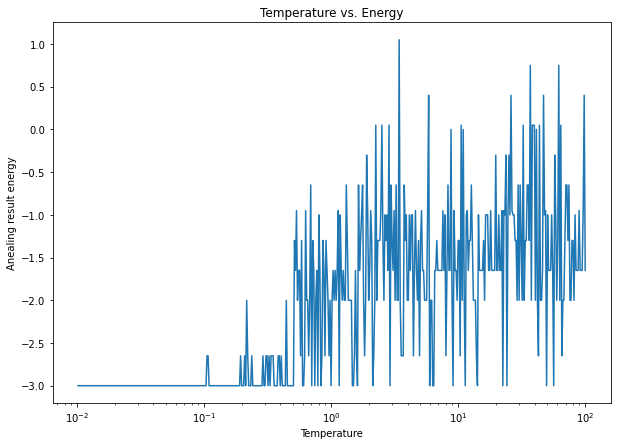

In [6]:
plt.figure(figsize=(10,7))
plt.title("Temperature vs. Energy")
plt.xlabel("Temperature")
plt.ylabel("Anealing result energy")
plt.xscale("log")
plt.plot(T[:-1],E_)
# Save figure
plt.savefig("./figures/task1_default_EvsT.png")
plt.show()

We can see that about 0.1 Kelvin the energy converges to minimum.  
Now, we try this with another cooling schedule. Firstly, compare several schedules.  
1) Given formula in task, 2) inverse formula, 3)inverse log formula 4) expoenetial*inverse : 
$$T_{1}(t) = \frac{T_{i}}{1+t} , T_{2}(t) = \frac{T_i}{1+log(1+t)}, T_{3}(t) = \frac{T_i(\frac{T_f}{T_i})^{\frac{t}{N}}}{1+t} (t>0)$$

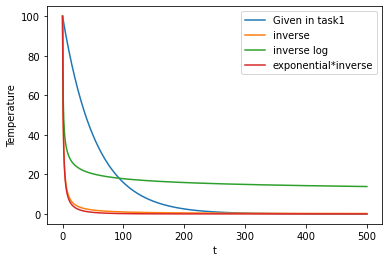

In [7]:
t = np.arange(N+1)
T1 = T_i/(t+1)
T2 = T_i/(1+np.log(1+t))
T3 = T_i * ((T_f/T_i) ** (t/N))/(t+1)
plt.plot(t,T,label = "Given in task1")
plt.plot(t,T1,label = "inverse")
plt.plot(t,T2,label = "inverse log")
plt.plot(t,T3,label= "exponential*inverse")
plt.xlabel("t")
plt.ylabel("Temperature")
plt.legend()
# Save figure
plt.savefig("./figures/task1_schedule_linear.png")
plt.show()

We know that; The increasing rate is $$log(t) < Poly(t) < Superpolynomial(t).$$
We chose the exponential coefficient 0.03 to compare with superpolynomial (given formula in this task).  
The first about 100 steps, inverse formula and exponential*inverse seem to converge faster than the others.  
But when we go to more steps, it seems the same. Let's see that graph with log y scale.

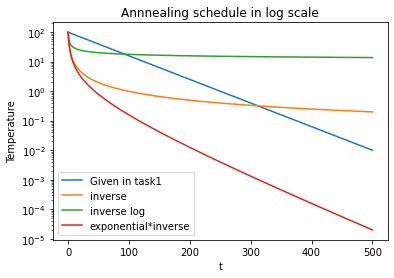

In [8]:
t = np.arange(N+1)
T1 = T_i/(t+1)
T2 = T_i/(1+np.log(1+t))
T3 = T_i * ((T_f/T_i) ** (t/N))/(t+1)
plt.title("Annnealing schedule in log scale")
plt.plot(t,T,label = "Given in task1")
plt.plot(t,T1,label = "inverse")
plt.plot(t,T2,label = "inverse log")
plt.plot(t,T3,label= "exponential*inverse")
plt.yscale("log")
plt.xlabel("t")
plt.ylabel("Temperature")
plt.legend()
# Save figure
plt.savefig("./figures/task1_schedule_log.png")
plt.show()

As we expected, exponential formula is faster than any other formulas.  
So firstly, simulate with inverse cooling schedule.

6


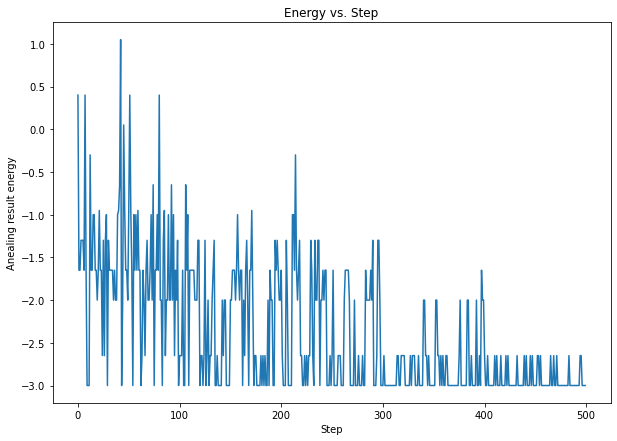

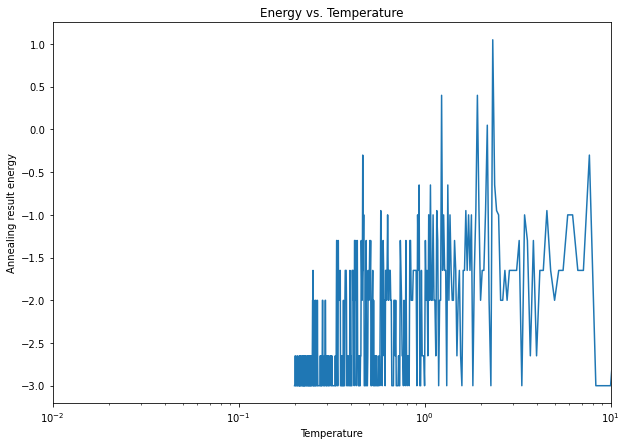

In [9]:
u = 1.35
V = 6

# generate a random graph with 'V' vertices
#graph = [(np.random.uniform(low=0, high=5), np.random.uniform(low=0, high=5)) for i in range(V)]

graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)
N = 500
t = np.arange(N+1)
T_i = 100
T_f = 0.01
E_ = []


for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T1[t]
    E = udmis.mc_step(T=temp)
    E_.append(E)

t = np.arange(N)

plt.figure(figsize=(10,7))
plt.title("Energy vs. Step")
plt.xlabel("Step")
plt.ylabel("Anealing result energy")
plt.plot(t,E_)
# Save figure
plt.savefig("./figures/task1_T1_EvsStep.png")
plt.show()

plt.figure(figsize=(10,7))
plt.title("Energy vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("Annealing result energy")
plt.xscale("log")
plt.xlim(0.01,10)
plt.plot(T1[:-1],E_)
# Save figure
plt.savefig("./figures/task1_T1_EvsT.png")
plt.show()

Even when it simulates with final steps, but it seems not to converge to minimum value well.
It may be related to temperature. Then what about log schedule? does it work worse than this?

6


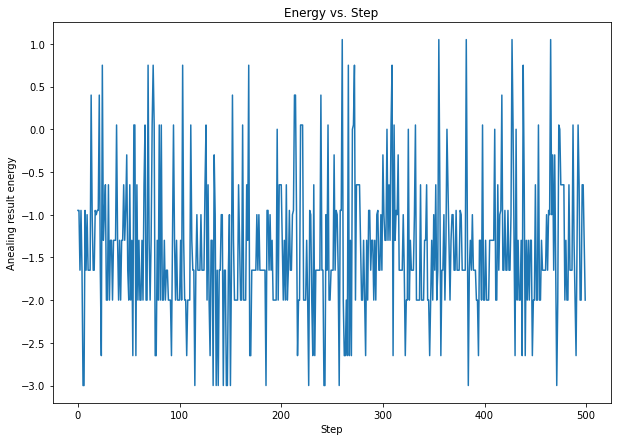

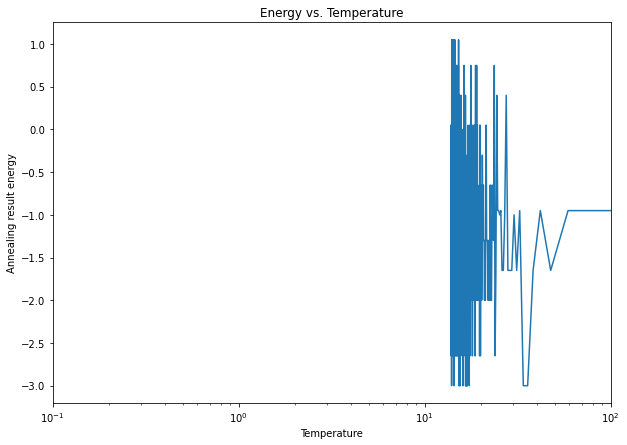

In [10]:
u = 1.35
V = 6

# generate a random graph with 'V' vertices
#graph = [(np.random.uniform(low=0, high=5), np.random.uniform(low=0, high=5)) for i in range(V)]

graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)
N = 500
t = np.arange(N+1)
T_i = 100
T_f = 0.01
E_ = []


for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T2[t]
    E = udmis.mc_step(T=temp)
    E_.append(E)

t = np.arange(N)

plt.figure(figsize=(10,7))
plt.title("Energy vs. Step")
plt.xlabel("Step")
plt.ylabel("Anealing result energy")
plt.plot(t,E_)
# Save figure
plt.savefig("./figures/task1_T2_EvsStep.png")
plt.show()

plt.figure(figsize=(10,7))
plt.title("Energy vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("Annealing result energy")
plt.xscale("log")
plt.xlim(0.1,100)
plt.plot(T2[:-1],E_)
# Save figure
plt.savefig("./figures/task1_T2_EvsT.png")
plt.show()

Log schedule does not converge to any value;  
since the temperature does not go under 10, it still can fluctuate various value.
Temperature is important; When temperature decrease more faster, then energy will converge to minimum value more faster.  
Finally, we simulate again with exponential*inverse cooling schedule.

6


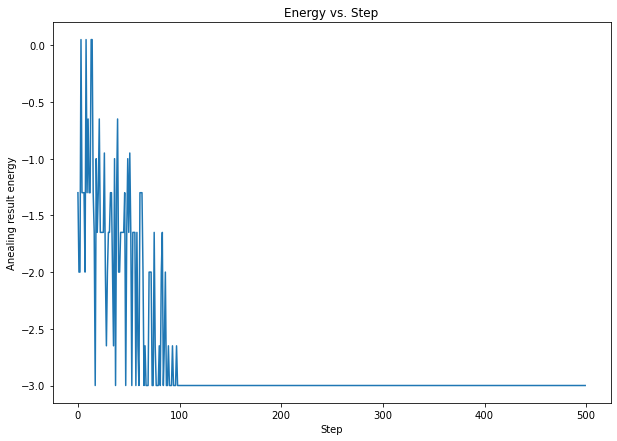

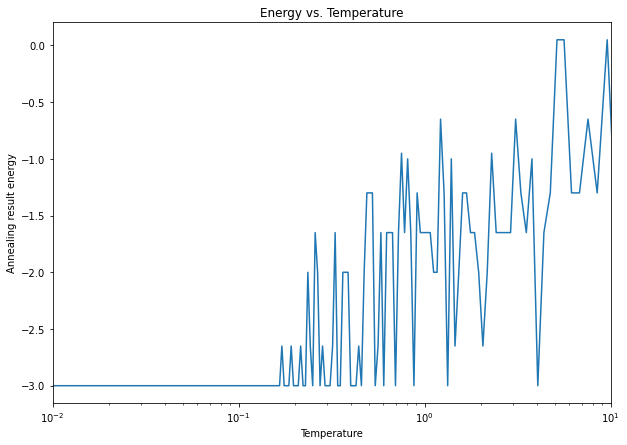

In [11]:
u = 1.35
V = 6

# generate a random graph with 'V' vertices
#graph = [(np.random.uniform(low=0, high=5), np.random.uniform(low=0, high=5)) for i in range(V)]

graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)
N = 500
t = np.arange(N+1)
T_i = 100
T_f = 0.01
E_ = []


for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T3[t]
    E = udmis.mc_step(T=temp)
    E_.append(E)

t = np.arange(N)

plt.figure(figsize=(10,7))
plt.title("Energy vs. Step")
plt.xlabel("Step")
plt.ylabel("Anealing result energy")
plt.plot(t,E_)
# Save figure
plt.savefig("./figures/task1_T3_EvsStep.png")
plt.show()

plt.figure(figsize=(10,7))
plt.title("Energy vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("Annealing result energy")
plt.xscale("log")
plt.xlim(0.01,10)
plt.plot(T3[:-1],E_)
# Save figure
plt.savefig("./figures/task1_T3_EvsT.png")
plt.show()

Energy gets minimum values about 100 steps and about 0.1 temperature.  
When temperature decreases faster, the energy converges faster.